In [1]:
import numpy as np
from scipy.stats import norm, lognorm, multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append("..")
from src.dataset import CRKPTransmissionSimulator
from src.approx_bc import abc_rejection_sampler
from src.utils import get_results
from timeit import default_timer as timer
import matplotlib.gridspec as gs

In [2]:
## load data
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed/resampled'

In [3]:
with open(f"{epi_dir}/observed_data.npy", "rb") as f:
            x_o = np.load(f)

# Data Visualization

In [6]:
crkp_model = CRKPTransmissionSimulator(epi_dir, 0, 1, heterogeneous=False)
x_baseline = crkp_model.CRKP_simulator(-1e8, 100)

infections = pd.read_csv(f"{epi_dir}/infections.csv", index_col=0)
infections.columns=np.arange(53)

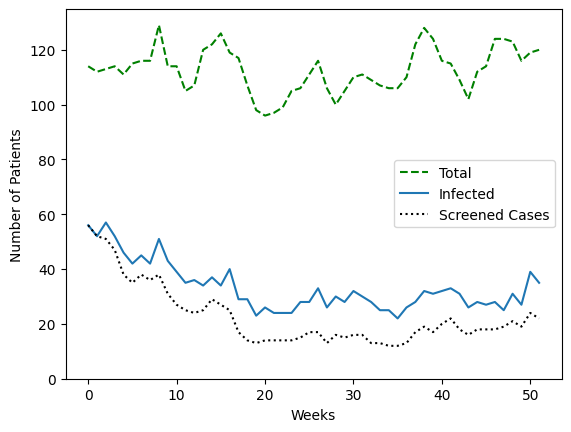

In [7]:
NN = infections.notna().sum(0)[:-1]
II = (infections == 1).sum(0)[:-1]
sns.lineplot(NN, color="green", linestyle="--", label="Total")
sns.lineplot(II, label="Infected")
sns.lineplot(x_baseline[:-1], linestyle=":", color="k", label="Screened Cases")
plt.ylim(bottom=0)
plt.ylabel("Number of Patients")
plt.xlabel("Weeks")
# plt.savefig("images/crkp.png")
plt.show()

In [9]:
# population by floor?

In [31]:
floor_pops = []
for i in range(1, 7):
    floor_pops.append((crkp_model.F == i).sum(0))
floor_pops = np.stack(floor_pops)

floor_cases = x_o[1:7,]

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [37]:
floor_pops[4]

array([1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0])

In [35]:
floor_pops[4].replace(0, 1)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'

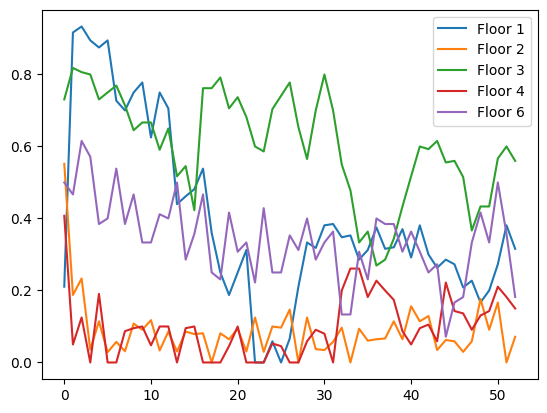

In [41]:
for i in [0, 1, 2, 3, 5]:
    temp_pop = np.where(floor_pops[i] == 0, 1, floor_pops[i])
    plt.plot(floor_cases[i] / temp_pop, label=f"Floor {i+1}")
plt.legend()
plt.show()

In [51]:
# average case burden
for i in [0, 1, 2, 3, 4, 5]:
    temp_pop = np.where(floor_pops[i] == 0, 1, floor_pops[i])
    avg_burden = np.median(floor_cases[i] / temp_pop) # median is clearer
    print(f"Floor {i+1}: {avg_burden:.2f}")

Floor 1: 0.32
Floor 2: 0.08
Floor 3: 0.60
Floor 4: 0.10
Floor 5: 0.00
Floor 6: 0.33


In [74]:
X = infections.values
T = X.shape[1]
room_count = np.zeros(T)
room_infect_density = np.ones(T)
for t in range(53):
    r = crkp_model.R[:, t]
    x = X[:, t]
    rx, ry = np.meshgrid(r, r)
    rC = (rx == ry).astype(int)
    I = (x == 1).astype(int)
    infected_roommates = (rC * I).sum(1)
    rm.append(infected_roommates.sum())
    if infected_roommates.max() > 0:
        room_infect_density[t] = infected_roommates[infected_roommates > 0].mean()
    room_count[t] = (infected_roommates > 1).sum()

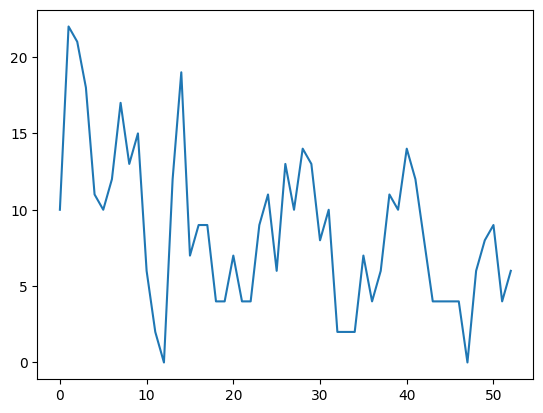

In [79]:
plt.plot(room_count)

In [50]:
np.median(II / NN)

0.27055180180180183

## homogeneous run

In [5]:
prior_mu = -1
prior_sigma = 1

In [6]:
# best run: n_sample = 4k, d_model = 80 patience = 50
mu = 0.002
sigma = 0.169

d = norm(loc = mu, scale = sigma)
np.exp(d.ppf(0.05)), np.exp(d.ppf(0.95))

(0.7588279076341541, 1.3231036979222353)

In [7]:
np.exp(0.002 + 0.169**2/2)

1.0164137494807186

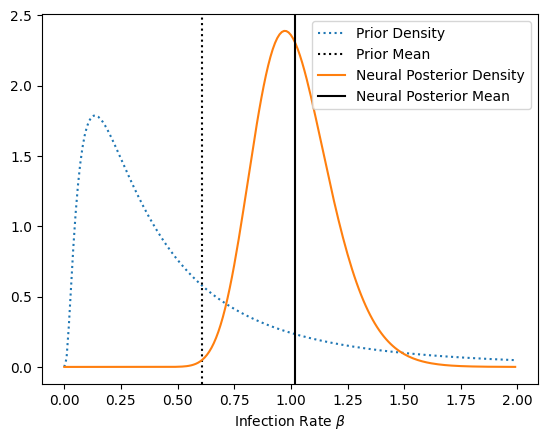

In [8]:
prior_mean = np.exp(prior_mu + prior_sigma**2/2)
prior = norm(prior_mu, prior_sigma)
x = np.arange(0., 2, 0.01)
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Neural Posterior Density")
plt.axvline(posterior_mean, color="k", label="Neural Posterior Mean")
ax.set_xlabel(r"Infection Rate $\beta$")
plt.legend()
plt.savefig("images/crkp_homog.png")
plt.show()

#### posterior predictive checks

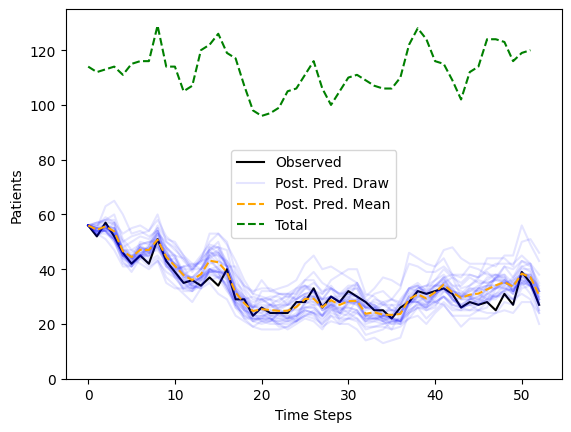

In [12]:
neural_posterior = norm(mu, sigma)
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_ppc1.png")
plt.ylim(0, 135)
plt.show()

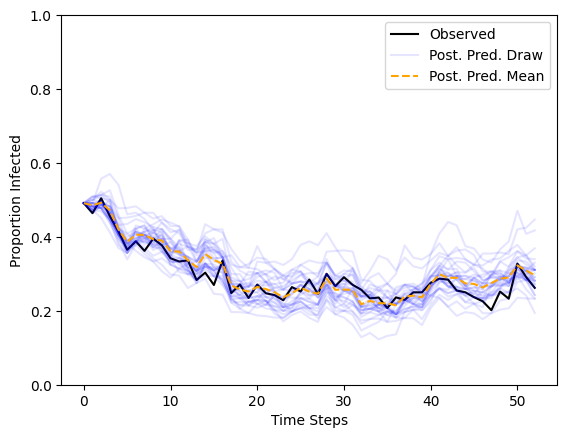

In [13]:
neural_posterior = norm(mu, sigma)
K = 30
T = x_o.shape[1]
pop = crkp_model.W.sum(0)
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i) / pop
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0] / pop
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
# plt.plot(x_baseline, label="Only Admitted", linestyle=":", color="k")
# plt.plot(pop, label="Population", color="g", linestyle=":")
plt.legend()
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.ylim(0, 1)
# plt.savefig("images/crkp_ppc2.png")
plt.show()

## Heterogeneous

In [87]:
prior_mu =  np.zeros(8)
prior_sigma = np.ones(8) # [1, 1, 1, 1, 1, 1, 1, 1]

#### viz

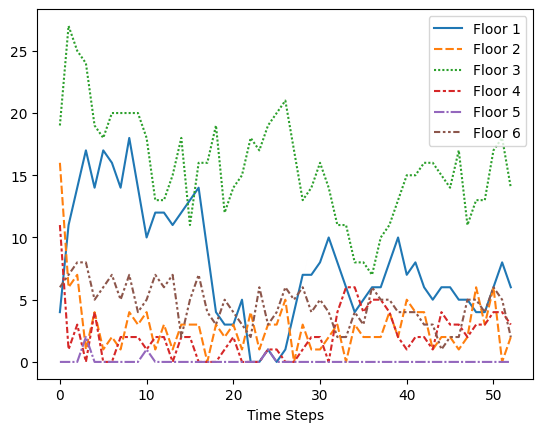

In [88]:
data = x_o[1:7,:]

data = pd.DataFrame(data = data.T, columns= [f"Floor {i}" for i in range(1,7)])

sns.lineplot(data)
# plt.ylim((0,1))
plt.xlabel("Time Steps")
# plt.ylabel("Proportion Infected")
# plt.savefig("images/hetero_infection_viz.png")
plt.show()

#### prior predictive checks

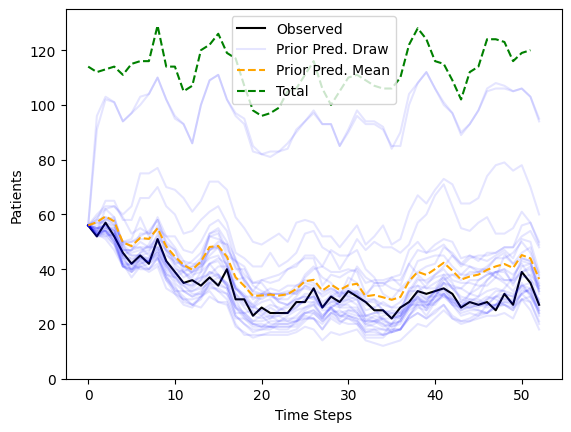

In [89]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
neural_posterior = multivariate_normal(prior_mu, np.diag(prior_sigma))
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep[0])
pp_mean = posterior_predictive.mean(0)
labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Prior Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_ppc_het.png")
plt.ylim(0, 135)
plt.show()

In [ ]:
# # get_results("../multirun/2024-10-08/14-51-04")# get_results("../multirun/2024-10-08/13-11-05") # get_results("../multirun/2024-10-08/13-29-54")

In [91]:
df_het = get_results("../outputs/2024-10-10/16-29-24", multirun=False) 
df_het = df_het[df_het["mean_field"] == False]

In [92]:
mu = np.array(df_het["mu"].iloc[0][0])
sigma = np.array(df_het["sigma"].iloc[0])
rates = []
for i in range(8):
    rates.append(np.exp(mu[i] + sigma[i][i]/2))
rates = np.array(rates)

In [93]:
mu

array([-1.12793291, -0.06660507, -0.16664605, -0.12195852, -0.08092462,
       -0.06721988, -0.01643751,  0.00914159])

In [94]:
rates

array([0.33921131, 1.61728419, 1.2882639 , 1.36226164, 1.45519841,
       1.50339874, 1.54235666, 1.6278636 ])

#### posterior predictive checks

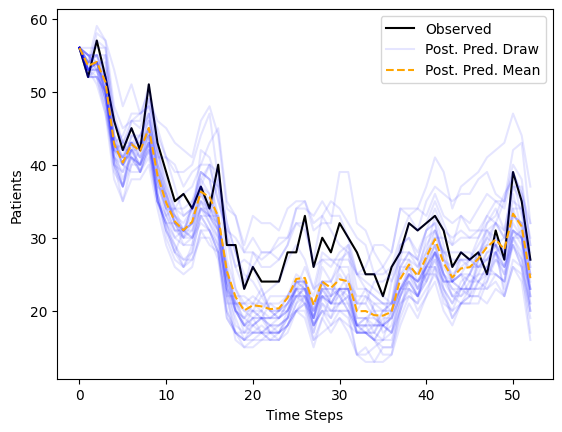

In [95]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
j = 0
neural_posterior = multivariate_normal(mu, sigma)
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep[j])
pp_mean = posterior_predictive.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[j]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
# sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_ppc_het.png")
# plt.ylim(0, 135)
plt.show()

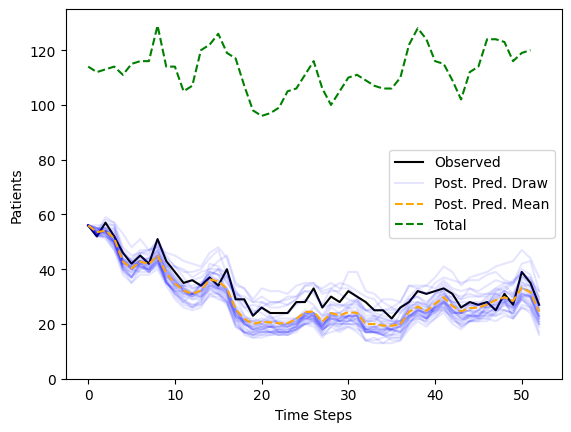

In [96]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
neural_posterior = multivariate_normal(mu, sigma)
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep[0])
pp_mean = posterior_predictive.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_ppc_het.png")
plt.ylim(0, 135)
plt.show()

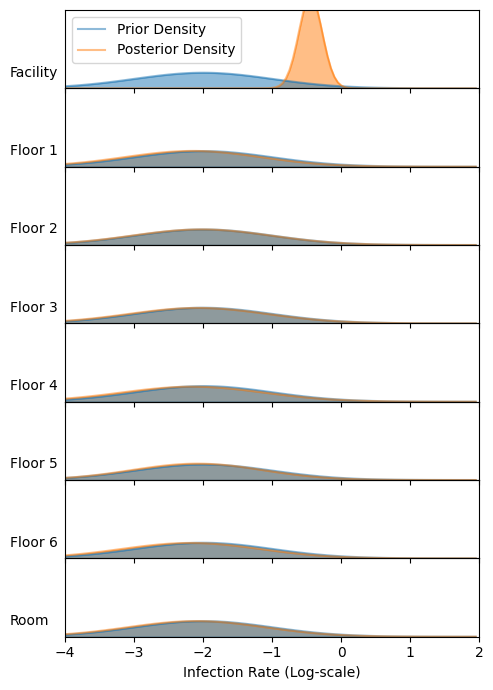

In [144]:
grid = gs.GridSpec(8, 1)
fig = plt.figure(figsize=(5,7))
x = np.arange(-4, 2, 0.05)
axes = []
labels = ["Facility"] + [f"Floor {i}" for i in range(1,7)] + ["Room"]
alpha = 0.5
for i in range(8):
    legend = False if i > 0 else True
    axes.append(fig.add_subplot(grid[i:i+1, 0:]))

    priory = norm.pdf(x, prior_mu[i], np.sqrt(prior_sigma[i]))
    posty = norm.pdf(x, mu[i], np.sqrt(sigma[i][i]))
    sns.lineplot(x=x, y=priory, label="Prior Density", ax=axes[-1], legend=legend, alpha=alpha)

    sns.lineplot(x=x, y=posty, label="Posterior Density", ax=axes[-1], legend=legend, alpha=alpha)

    rect = axes[-1].patch
    rect.set_alpha(0)

    axes[-1].set_yticklabels([])
    axes[-1].set_ylabel('')

    axes[-1].set_ylim(0, 2)
    axes[-1].set_xlim(-4, 2)

    axes[-1].set_yticks([])

    if i < 8 - 1:
        axes[-1].set_xticklabels([])
    else:
        axes[-1].set_xlabel("Infection Rate (Log-scale)")

    axes[-1].fill_between(x, posty, color='#ff7f0e', alpha=alpha)
    axes[-1].fill_between(x, priory, color='#1f77b4', alpha=alpha)


    axes[-1].text(-4.8, 0.3, labels[i])
grid.update(hspace= -.0)
plt.tight_layout()
# plt.savefig("images/crkp_compare_het.png")
plt.show()
    

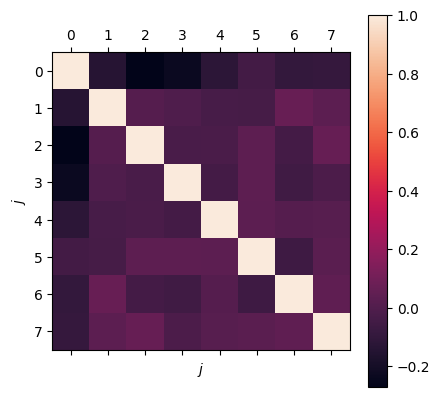

In [126]:
D = np.diag(1 / np.sqrt(np.diag(sigma)))
corr = D @ sigma @ D
plt.matshow(corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$j$")
plt.ylabel(r"$j$")
# plt.savefig("images/corr.png")
plt.show()

#### make me a table jack

In [63]:
het_table = {"Rate": labels, 
             "Posterior Mean": np.round(np.array(rates), 3), 
             "CI": []}

for i in range(8):
    dist = norm(mu[i], np.sqrt(sigma[i][i]))
    het_table["CI"].append(
        (np.round(np.exp(dist.ppf(0.05)), 3), 
         np.round(np.exp(dist.ppf(0.95)), 3)))

In [64]:
het_table = pd.DataFrame(het_table)

In [65]:
print(het_table.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
Rate & Posterior Mean & CI \\
\midrule
Facility & 0.465000 & (0.323, 0.642) \\
Floor 1 & 0.063000 & (0.009, 0.191) \\
Floor 2 & 0.074000 & (0.009, 0.23) \\
Floor 3 & 4.067000 & (1.6, 8.104) \\
Floor 4 & 0.077000 & (0.007, 0.257) \\
Floor 5 & 0.074000 & (0.008, 0.234) \\
Floor 6 & 0.072000 & (0.008, 0.231) \\
Room & 1.738000 & (0.207, 5.439) \\
\bottomrule
\end{tabular}



## ABC Sanity Check

In [80]:
summarize = False #True
hetero = True


prior_mu = np.zeros(8)
prior_sigma = np.ones(8)
model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma,
                                  heterogeneous=hetero)

In [81]:
prior_sampler = lambda: model.sample_logbeta(1)
simulator = lambda theta, seed: model.CRKP_simulator(theta, seed)

S = 100
epsilon = 40
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, max_attempts=15000,
    summarize=summarize
)

Attempts: 5,000
Time lapsed: 46.37 seconds
With tolerance 40, acceptance rate: 0.016466
Total number of attempts: 6,073


In [82]:
posterior_sample.mean(0)

array([-0.8002739 ,  0.26887083, -0.12224162,  0.5910202 , -0.26981774,
        0.06909456, -0.08784015,  0.07793891], dtype=float32)

In [83]:
posterior_sample.std(0)

array([0.44415814, 1.0133107 , 0.8386373 , 1.1078455 , 0.97616714,
       1.0199147 , 1.0518078 , 1.0656997 ], dtype=float32)

In [84]:
np.exp(posterior_sample).mean(0)

array([0.49088407, 2.0337658 , 1.2607112 , 2.8750868 , 1.1591953 ,
       1.7493428 , 1.5812346 , 1.8443899 ], dtype=float32)

In [85]:
np.exp(posterior_sample).std(0)

array([0.19088387, 1.8617744 , 1.187779  , 2.5767765 , 1.0436063 ,
       1.8977586 , 1.9453137 , 2.2029693 ], dtype=float32)

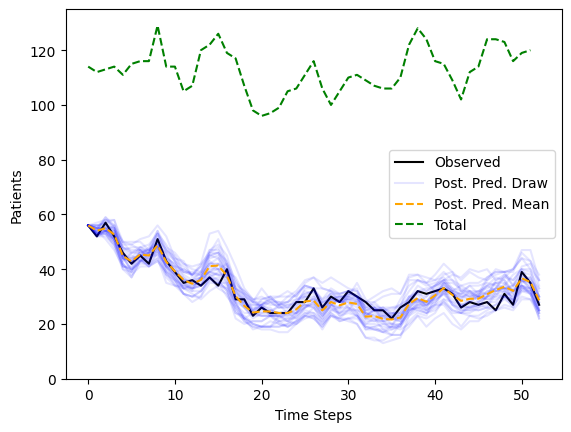

In [86]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
j = 0
K = 30
T = x_o.shape[1]
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(posterior_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep[j])
pp_mean = posterior_predictive.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[j]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_ppc_het.png")
plt.ylim(0, 135)
plt.show()

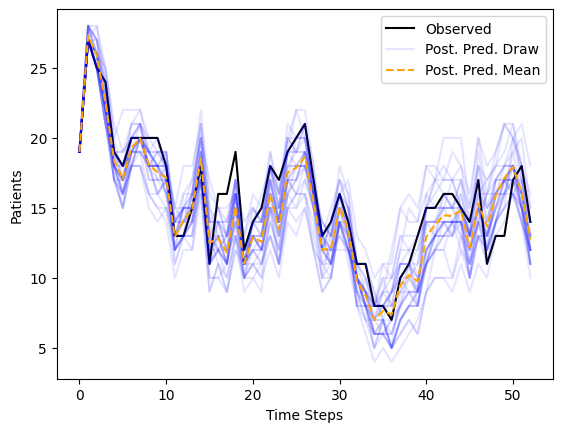

In [92]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
j = 3
K = 30
T = x_o.shape[1]
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(posterior_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep[j])
pp_mean = posterior_predictive.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[j]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
# sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_ppc_het.png")
# plt.ylim(0, 135)
plt.show()

In [ ]:
# posterior predictive check for floor

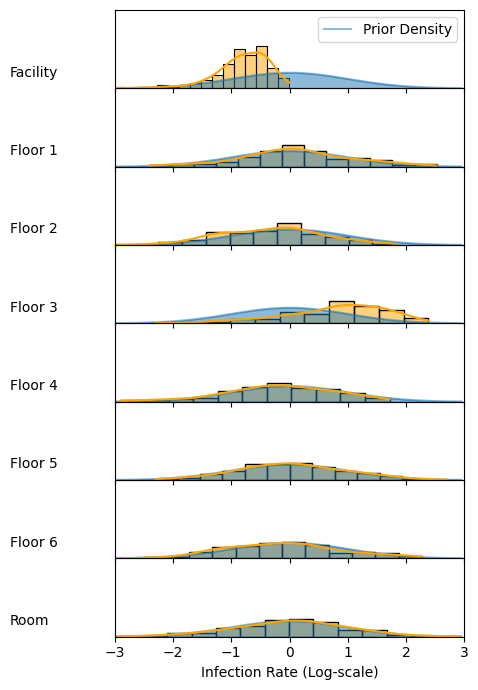

In [72]:
grid = gs.GridSpec(8, 1)
fig = plt.figure(figsize=(5,7))
xmin, xmax = -3, 3

x = np.arange(xmin, xmax, 0.05)
axes = []
labels = ["Facility"] + [f"Floor {i}" for i in range(1,7)] + ["Room"]
alpha = 0.5
for i in range(8):
    legend = False if i > 0 else True
    axes.append(fig.add_subplot(grid[i:i+1, 0:]))

    priory = norm.pdf(x, prior_mu[i], np.sqrt(prior_sigma[i]))
    # posty = norm.pdf(x, mu[i], np.sqrt(sigma[i][i]))
    sns.lineplot(x=x, y=priory, label="Prior Density", ax=axes[-1], legend=legend, alpha=alpha)

    sns.histplot(posterior_sample[:, i], color="orange", ax=axes[-1], legend=legend, alpha=alpha, stat="density",
                kde=True, label="ABC Posterior")

    post_mean = np.mean(posterior_sample[:, i])

    # plt.axvline(post_mean, color="k", linestyle="--")

    # sns.lineplot(x=x, y=posty, label="Posterior Density", ax=axes[-1], legend=legend, alpha=alpha)

    rect = axes[-1].patch
    rect.set_alpha(0)

    axes[-1].set_yticklabels([])
    axes[-1].set_ylabel('')

    axes[-1].set_ylim(0, 2)
    axes[-1].set_xlim(xmin, xmax)

    axes[-1].set_yticks([])

    if i < 8 - 1:
        axes[-1].set_xticklabels([])
    else:
        axes[-1].set_xlabel("Infection Rate (Log-scale)")

    # axes[-1].fill_between(x, posty, color='#ff7f0e', alpha=alpha)
    axes[-1].fill_between(x, priory, color='#1f77b4', alpha=alpha)


    axes[-1].text(-4.8, 0.3, labels[i])
grid.update(hspace= -.0)
plt.tight_layout()
# plt.savefig("images/crkp_compare_het.png")
plt.show()

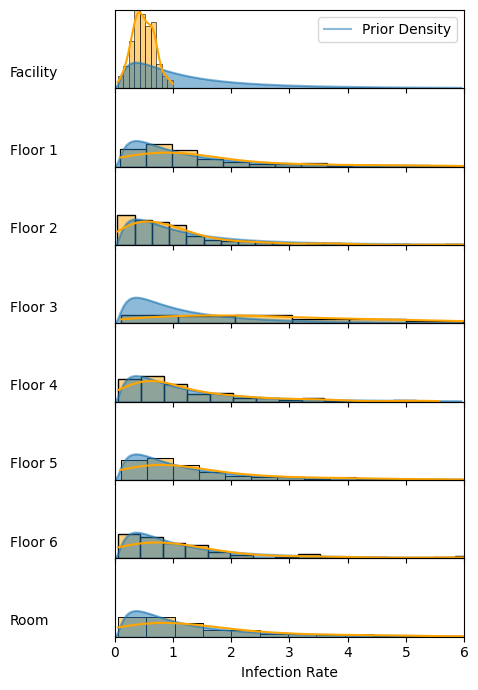

In [69]:
grid = gs.GridSpec(8, 1)
fig = plt.figure(figsize=(5,7))
xmin, xmax = 0, 6

x = np.arange(xmin, xmax, 0.05)
axes = []
labels = ["Facility"] + [f"Floor {i}" for i in range(1,7)] + ["Room"]
alpha = 0.5
for i in range(8):
    legend = False if i > 0 else True
    axes.append(fig.add_subplot(grid[i:i+1, 0:]))

    priory = lognorm.pdf(x, scale = np.exp(prior_mu[i]), s = np.sqrt(prior_sigma[i]))
    # posty = norm.pdf(x, mu[i], np.sqrt(sigma[i][i]))
    sns.lineplot(x=x, y=priory, label="Prior Density", ax=axes[-1], legend=legend, alpha=alpha)

    sns.histplot(np.exp(posterior_sample[:, i]), color="orange", ax=axes[-1], legend=legend, alpha=alpha, stat="density",
                kde=True)

    # sns.lineplot(x=x, y=posty, label="Posterior Density", ax=axes[-1], legend=legend, alpha=alpha)

    rect = axes[-1].patch
    rect.set_alpha(0)

    axes[-1].set_yticklabels([])
    axes[-1].set_ylabel('')

    axes[-1].set_ylim(0, 2)
    axes[-1].set_xlim(xmin, xmax)

    axes[-1].set_yticks([])

    if i < 8 - 1:
        axes[-1].set_xticklabels([])
    else:
        axes[-1].set_xlabel("Infection Rate")

    # axes[-1].fill_between(x, posty, color='#ff7f0e', alpha=alpha)
    axes[-1].fill_between(x, priory, color='#1f77b4', alpha=alpha)


    axes[-1].text(-1.8, 0.3, labels[i])
grid.update(hspace= -.0)
plt.tight_layout()
# plt.savefig("images/crkp_compare_het.png")
plt.show()

In [124]:
abc_corr = np.corrcoef(posterior_sample.T)

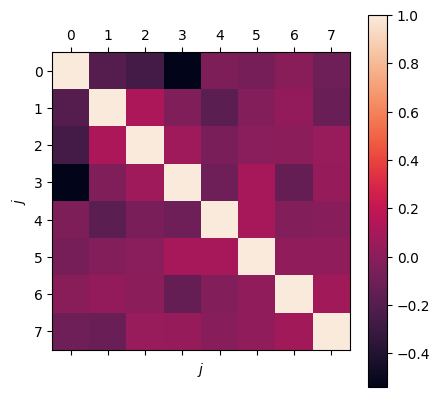

In [126]:
plt.matshow(abc_corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$j$")
plt.ylabel(r"$j$")
# plt.savefig("images/corr.png")
plt.show()

## more sanity checks...

In [114]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
j = 3
# neural_posterior = multivariate_normal(mu, sigma)
K = 100
T = x_o.shape[1]
# npe_sample = neural_posterior.rvs(size=K, random_state=2)
f3 = np.zeros(K)
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(posterior_sample[i], i)
    f3[i] =  x_rep[3].mean()

In [119]:
posterior_sample[:, 3].shape

(200,)

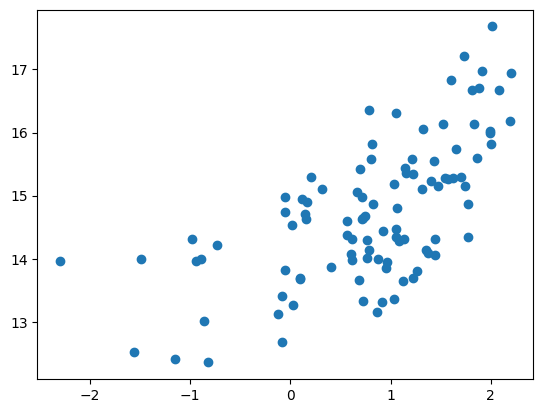

In [120]:
plt.scatter(x=posterior_sample[:100, 3], y=f3)

In [112]:
logbeta3s = posterior_sample[:, 3]

In [104]:
posterior_sample.mean(0)

array([-0.7996313 ,  0.11157224, -0.31457597,  0.78197336, -0.16992295,
        0.04438194, -0.08668156,  0.01421784], dtype=float32)